# Data Drift Detector Examples

This notebook contains examples that show how to set up, run, and produce output from detectors in the 
data_drift module. The parameters aren't necessarily tuned for best 
performance for the input data, just notional. These detectors are generally
applied to the whole feature set for a given data source. 

The example data for PCA-CD and KDQ-Tree, Circle, is a synthetic data source, where drift
occurs in both var1, var2, and the conditional distributions P(y|var1) and
P(y|var2). The drift occurs from index 1000 to 1250, and affects 66% of the
sample.

In [1]:
## Imports ##

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from menelaus.data_drift.cdbd import CDBD
from menelaus.data_drift.hdddm import HDDDM
from menelaus.data_drift import PCACD
from menelaus.data_drift import KdqTreeStreaming, KdqTreeBatch
from menelaus.datasets import make_example_batch_data, fetch_circle_data

In [2]:
## Import Data ##

# Import CDBD and HDDDM Data
example_data = make_example_batch_data()

# Import PCA-CD and KDQ-Tree Data (circle dataset)
circle_data = fetch_circle_data()

## Confidence Distribution Batch Detection (CDBD)

This section details how to setup, run, and produce plots for CDBD. This script
monitors the feature "confidence", simulated confidence scores output by a
classifier. Drift occurs in 2018 and persists through 2021. See
src/menelaus/tools/artifacts/README_example_data.txt for more info.

CDBD must be setup and run with batches of data containing 1 variable. 

Plots include: 

- A line plot visualizing test statistics for detection of drift

In [ ]:
## Setup ##

# Set up reference and test batches, using 2007 as reference year
reference = pd.DataFrame(example_data[example_data.year == 2007].loc[:, "confidence"])
all_test = example_data[example_data.year != 2007]

# Run CDBD
cdbd = CDBD(subsets=8)
cdbd.set_reference(reference)

# Store drift for test statistic plot
detected_drift = []
for year, subset_data in all_test.groupby("year"):
    cdbd.update(pd.DataFrame(subset_data.loc[:, "confidence"]))
    detected_drift.append(cdbd.drift_state)

Drift occurs in 2018 and persists through end of dataset. CDBD identifies drift
occurring in 2019, one year late. It alerts to a false alarm in 2012.



In [ ]:
## Plot Line Graph ##
# Calculate divergences for all years in dataset
years = list(example_data.year.value_counts().index[1:])
kl_divergence = [
    ep - th for ep, th in zip(cdbd.epsilon_values.values(), cdbd.thresholds.values())
]

# Remove potential infs that arise because of small confidence scores
kl_divergence = [
    x if np.isnan(x) == False and np.isinf(x) == False else 0 for x in kl_divergence
]

# Plot KL Divergence against Year, along with detected drift
plot_data = pd.DataFrame(
    {"Year": years, "KL Divergence": kl_divergence, "Detected Drift": detected_drift}
)
sns.set_style("white")
plt.figure(figsize=(20, 6))
plt.plot("Year", "KL Divergence", data=plot_data, label="KL Divergence", marker=".")
plt.grid(False, axis="x")
plt.xticks(years, fontsize=16)
plt.yticks(fontsize=16)
plt.title("CDBD Test Statistics", fontsize=22)
plt.ylabel("KL Divergence", fontsize=18)
plt.xlabel("Year", fontsize=18)
plt.ylim([min(kl_divergence) - 0.02, max(kl_divergence) + 0.02])
for _, t in enumerate(plot_data.loc[plot_data["Detected Drift"] == "drift"]["Year"]):
    plt.axvspan(
        t - 0.2, t + 0.2, alpha=0.5, color="red", label=("Drift Detected" if _ == 0 else None)
    )
plt.legend()
plt.axhline(y=0, color="orange", linestyle="dashed")

plt.show()
# plt.savefig("example_CDBD_test_statistics.png")

In [ ]:
### Custom Divergence Metric ### 

# Define divergence function
def distance_metric(reference_histogram, test_histogram):

    # Convert inputs to appropriate datatype 
    ref = np.array(reference_histogram[0])
    test = np.array(test_histogram[0])

    return np.sqrt(np.sum(np.square(ref-test)))

# Test self-defined divergence metric 
cdbd = CDBD(
    divergence=distance_metric,
    detect_batch=1,
    statistic="stdev",
    significance=0.05,
    subsets=5,
)

cdbd.set_reference(reference)
cdbd.update(pd.DataFrame(example_data[example_data.year == 2008].loc[:, "confidence"]))

## Hellinger Distance Drift Detection Method (HDDDM)

This section details how to setup, run, and produce plots for HDDDM, using both
numeric and categorical data. Drift occurs in 2009, 2012, 2015, 2018, and 2021.
Drift in 2018 persists through 2021. See
src/menelaus/tools/artifacts/README_example_data.txt for more info.
It additionally contains an example of using a custom divergence function. 

HDDDM must be setup and run with batches of data. 

Plots include:

- A line plot visualizing test statistics for detection of drift 

- A heatmap visualizing "where" drift is occuring, showing features for each
  year's test batch with the greatest Hellinger distance from the reference
  batch.

In [ ]:
## Setup ##

# Set up reference and test batches, using 2007 as reference year
# -2 indexing removes columns "drift" and "confidence"
reference = example_data[example_data.year == 2007].iloc[:, 1:-2]
all_test = example_data[example_data.year != 2007]

#  Setup HDDDM
np.random.seed(1)
hdddm = HDDDM(subsets=8)

# Store epsilons per feature for heatmap
years = all_test.year.unique()
heatmap_data = pd.DataFrame(columns = years)

# Store drift for test statistic plot
detected_drift = []

# Run HDDDM
hdddm.set_reference(reference)
for year, subset_data in example_data[example_data.year != 2007].groupby("year"):
    hdddm.update(subset_data.iloc[:, 1:-2])
    heatmap_data[year] = hdddm.feature_epsilons
    detected_drift.append(hdddm.drift_state)

HDDDM identifies drifts in 2009, 2010, 2012, 2019, 2021. These drifts involve
a change in mean or variance. Drift in 2010 is likely identified as the
distribution returns to state prior to 2009 drift. Drift in 2015, a change in
correlation, is undetected. Drift in 2018 is detected one year late.


In [ ]:
## Plot Line Graph ##
h_distances = [
    ep - th for ep, th in zip(hdddm.epsilon_values.values(), hdddm.thresholds.values())
]

# Plot Hellinger Distance against Year, along with detected drift
plot_data = pd.DataFrame(
    {"Year": years, "Hellinger Distance": h_distances, "Detected Drift": detected_drift}
)
sns.set_style("white")
plt.figure(figsize=(20, 6))
plt.plot(
    "Year", "Hellinger Distance", data=plot_data, label="Hellinger Distance", marker="."
)
plt.grid(False, axis="x")
plt.xticks(years, fontsize=16)
plt.yticks(fontsize=16)
plt.title("HDDDM Test Statistics", fontsize=22)
plt.ylabel("Hellinger Distance", fontsize=18)
plt.xlabel("Year", fontsize=18)
plt.ylim([min(h_distances) - 0.02, max(h_distances) + 0.02])
for _, t in enumerate(plot_data.loc[plot_data["Detected Drift"] == "drift"]["Year"]):
    plt.axvspan(
        t - 0.2, t + 0.2, alpha=0.5, color="red", label=("Drift Detected" if _ == 0 else None)
    )
plt.legend()
plt.axhline(y=0, color="orange", linestyle="dashed")

plt.show()
# plt.savefig("example_HDDDM_test_statistics.png")

- Drift in feature B is detected in 2009 and 2010 (as it reverts to normal).

- Drift in feature D is detected in 2012 and 2013 (as it reverts to normal).

- Drift in feature H is detected in 2019. Drift in feature J is detected in 2021.

- The undetected drift occurs in 2015 in the correlations between features E and F.


In [ ]:
## Plot Heatmap ##
sns.set_style("whitegrid")
sns.set(rc={"figure.figsize": (15, 8)})

# Setup plot

# Setup plot
grid_kws = {"height_ratios": (0.9, 0.05), "hspace": 0.3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
coloring = sns.cubehelix_palette(start=0.8, rot=-0.5, as_cmap=True)
ax = sns.heatmap(
    heatmap_data,
    ax=ax,
    cmap=coloring,
    xticklabels=heatmap_data.columns,
    yticklabels=heatmap_data.index,
    linewidths=0.5,
    cbar_ax=cbar_ax,
    cbar_kws={"orientation": "horizontal"},
)
ax.set_title('HDDDM Feature Heatmap')
ax.set(xlabel="Years", ylabel="Features")
ax.collections[0].colorbar.set_label("Difference in Hellinger Distance")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.show()
# plt.savefig("example_HDDDM_feature_heatmap.png")

In [ ]:
### Custom Divergence Metric ### 

# Define divergence function
def distance_metric(reference_histogram, test_histogram):

    # Convert inputs to appropriate datatype 
    ref = np.array(reference_histogram[0])
    test = np.array(test_histogram[0])

    return np.sqrt(np.sum(np.square(ref-test)))

# Test self-defined divergence metric 
hdddm = HDDDM(
    divergence=distance_metric,
    detect_batch=1,
    statistic="stdev",
    significance=0.05,
    subsets=5,
)

hdddm.set_reference(reference)
hdddm.update(example_data[example_data.year == 2008].iloc[:, 1:-2])

## PCA-Based Change Detection (PCA-CD)

PCA-CD is a drift detector that transforms the passed data into its principal components, then watches the transformed data for signs of drift by monitoring the KL-divergence via the Page-Hinkley algorithm.

In [ ]:
## Setup ##

pca_cd = PCACD(window_size=50, divergence_metric="intersection")

# set up dataframe to record results
status = pd.DataFrame(columns=["index", "var1", "var2", "drift_detected"])

# Put together a dataframe of several features, each of which abruptly changes
# at index 1000.
np.random.seed(1)
size = 1000
data = pd.concat(
    [
        pd.DataFrame(
            [
                np.random.normal(1, 10, size),
                np.random.uniform(1, 2, size),
                np.random.normal(0, 1, size),
            ]
        ).T,
        pd.DataFrame(
            [
                np.random.normal(9, 10, size),
                np.random.normal(1, 3, size),
                np.random.gamma(20, 30, size),
            ]
        ).T,
    ]
)

# Update the drift detector with each new sample
for i in range(len(circle_data)):
    pca_cd.update(data.iloc[[i]])
    status.loc[i] = [i, data.iloc[i, 0], data.iloc[i, 1], pca_cd.drift_state]

In [ ]:
## Plotting ##

# Plot the features and the drift
plt.figure(figsize=(20, 6))
plt.scatter(status.index, status.var2, label="Var 2")
plt.scatter(status.index, status.var1, label="Var 1", alpha=0.5)
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("PCA-CD Test Results", fontsize=22)
plt.ylabel("Value", fontsize=18)
plt.xlabel("Index", fontsize=18)
ylims = min(status.var1.min(), status.var2.min()), max(
    status.var1.max(), status.var1.max()
)
plt.ylim(ylims)

# Draw red lines that indicate where drift was detected
plt.vlines(
    x=status.loc[status["drift_detected"] == "drift"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Drift Detected",
    color="red",
)

plt.legend()

PCA-CD detects this very abrupt drift within a few samples of its induction.


In [ ]:
plt.show()
# plt.savefig("example_PCA_CD.png")

## KDQ-Tree Detection Method (Streaming Setting)

KdqTree monitors incoming features by constructing a tree which partitions the feature-space, and then monitoring a divergence statistic that is defined over that partition. It watches data within a sliding window of a particular size. When that window is full, it builds the reference tree. As the window moves forward, point-by-point, the data in that new window is compared against the reference tree to detect drift.

In [3]:
## Setup ##

# kdqTree does use bootstrapping to define its critical thresholds, so setting
# the seed is important to reproduce exact behavior.
np.random.seed(1)

# Note that the default input_type for KDQTree is "stream".
# The window size, corresponding to the portion of the stream which KDQTree
# monitors, must be specified.
det = KdqTreeStreaming(window_size=500, alpha=0.05, bootstrap_samples=500, count_ubound=50)

# setup DF to record results
status = pd.DataFrame(columns=["index", "var1", "var2", "drift_detected"])

# iterate through X data and run detector
data = circle_data[["var1", "var2"]]

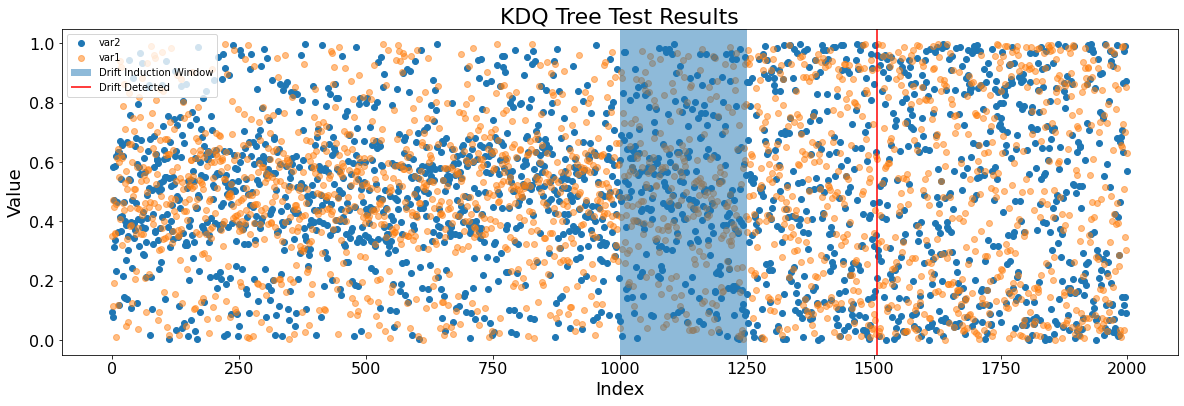

In [4]:
## Plotting ##

plot_data = {}
for i in range(len(circle_data)):
    det.update(data.iloc[[i]])
    status.loc[i] = [i, data.iloc[i, 0], data.iloc[i, 1], det.drift_state]
    if det.drift_state is not None:
        # capture the visualization data
        plot_data[i] = det.to_plotly_dataframe()

plt.figure(figsize=(20, 6))
plt.scatter("index", "var2", data=status, label="var2")
plt.scatter("index", "var1", data=status, label="var1", alpha=0.5)
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("KDQ Tree Test Results", fontsize=22)
plt.ylabel("Value", fontsize=18)
plt.xlabel("Index", fontsize=18)
ylims = [-0.05, 1.05]
plt.ylim(ylims)

drift_start, drift_end = 1000, 1250
plt.axvspan(drift_start, drift_end, alpha=0.5, label="Drift Induction Window")

# Draw red lines that indicate where drift was detected
plt.vlines(
    x=status.loc[status["drift_detected"] == "drift"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Drift Detected",
    color="red",
)

plt.legend()
plt.show()
# plt.savefig("example_streaming_kdqtree_feature_stream.png")

Given a window_size of 500, with only the two input features, KdqTree detects
a change after about half of the data within its window is in the new regime.


If we save off the to_plotly_dataframe at each drift detection, we can display
the Kulldorff Spatial Scan Statistic (KSS) for each. Higher values of KSS
indicate that a given region of the data space has greater divergence between
the reference and test data.

Note that the structure of the particular tree depends on the reference data
and the order of the columns within the dataframe!

Since this data only contains two features, the tree is relatively
shallow.

In [5]:
## Kulldorff Spatial Scan Statistic (KSS) ##
for title, df_plot in plot_data.items():
    fig = px.treemap(
        data_frame=df_plot,
        names="name",
        ids="idx",
        parents="parent_idx",
        color="kss",
        color_continuous_scale="blues",
        title=f"Index {title}",
    )
    fig.update_traces(root_color="lightgrey")
    fig.show()
    # fig.write_html(f"example_streaming_kdqtree_treemap_{title}.html")

## KDQ-Tree Detection Method (Batch Setting)

This example shows up how to set up, run, and produce output from the kdq-Tree
detector, specifically in the batch data setting. The parameters aren't 
necessarily tuned for best performance, just notional.

Drift in the example dataset occurs in 2009, 2012, 2015, 2018, and 2021. Drift
in 2018 persists through 2021. See
src/menelaus/tools/artifacts/README_example_data.txt for more details.

This example takes roughly a minute to run.

In [ ]:
## Setup ##

# kdq-Tree does use bootstrapping to define its critical thresholds, so setting
# the seed is important to reproduce exact behavior.
np.random.seed(123)

df = example_data

# Capture the column which tells us when drift truly occurred
drift_years = df.groupby("year")["drift"].apply(lambda x: x.unique()[0]).reset_index()

# Because the drift in 2009, 2012, and 2016 is intermittent - it reverts
# back to the prior distribution in the subsequent year - we should also detect
# drift in 2010, 2013, and 2016. So:
drift_years.loc[drift_years["year"].isin([2010, 2013, 2016]), "drift"] = True


df.drop(columns=["cat", "confidence", "drift"], inplace=True)


plot_data = {}
status = pd.DataFrame(columns=["year", "drift"])
det = KdqTreeBatch()

# Set up reference batch, using 2007 as reference year
det.set_reference(df[df.year == 2007].drop(columns=['year']))

In [ ]:
# Batch the data by year and run kdqTree
for group, sub_df in df[df.year != 2007].groupby("year"):
    det.update(sub_df.drop(columns=["year"]))
    status = pd.concat(
        [status, pd.DataFrame({"year": [group], "drift": [det.drift_state]})],
        axis=0,
        ignore_index=True,
    )
    if det.drift_state is not None:
        # capture the visualization data
        plot_data[group] = det.to_plotly_dataframe()
        
        # option to specify reference batch to be any year 
        #det.set_reference(df[df.year == XXXX])

Print out the true drift status, and that according to the detector.
The detector successfully identifies drift in every year but 2018;
that's the first year where persistent drift, from 2018-2021, was induced.
The detector picks it up in 2019, the second year of persistent drift.

In [ ]:
(
    status.merge(drift_years, how="left", on="year", suffixes=["_kdqTree", "_true"])
    .replace({True: "drift", False: None})
    # .to_csv("example_kdqtree_drift_comparison.csv", index=False)
)

If we save off the to_plotly_dataframe at each drift detection, we can display
the Kulldorff Spatial Scan Statistic (KSS) for each. Higher values of KSS
indicate that a given region of the data space has greater divergence between
the reference and test data.

In [ ]:
for year, df_plot in plot_data.items():
    fig = px.treemap(
        data_frame=df_plot,
        names="name",
        ids="idx",
        parents="parent_idx",
        color="kss",
        color_continuous_scale="blues",
        title=year,
    )
    fig.update_traces(root_color="lightgrey")
    fig.show()
    # fig.write_html(f"example_kdqtree_treemap_{year}.html")


We can see that the regions of greatest drift do line up with at least one of
the items that were modified in a given year.

For reference, the detailed descriptions of drift induction:

- Drift 1: change the mean & var of item B in 2009, means will revert for 2010 on

- Drift 2: change the variance of item c and d in 2012 by replacing some with the mean
    keep same mean as other years, revert by 2013

- Drift 3: change the correlation of item e and f in 2015 (go from correlation of 0 to correlation of 0.5)

- Drift 4: change mean and var of H and persist it from 2018 on

- Drift 5: change mean and var just for a year of J in 2021
